<a href="https://colab.research.google.com/github/Maria-Ul/Inverse-Scattering-Problem/blob/master/Train_test_generated_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from google.colab import drive
import math
from sklearn.metrics import mean_absolute_error,  mean_absolute_percentage_error


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Dataset(Dataset):

    def __init__(self, csv_file, transform=None):

        self.data = pd.read_csv(csv_file , index_col=0 , header=0).to_numpy()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        features = np.array(sample[2:],  dtype=np.float32)
        labels = np.array([sample[0], sample[1]], dtype=np.float32)

        if self.transform is not None:
            sample = self.transform(theta_array = torch.linspace(10, 65, len(features)), data_arr = features, noise = True, snr = 3)

        return  features, labels

In [ ]:
def Mal_func(theta_array , data_arr, noise = False, snr = 3):
  vector_length = len(theta_array)
  w_array = np.zeros(vector_length)
  for i in range(vector_length):
      theta = theta_array[i]
      w = 1/theta*math.exp(-2*(math.log(theta/54, math.e))**2)
      w_array[i] = w
      data_arr[i] = data_arr[i]*w_array[i]

  if noise == True:
    min_val = min(data_arr)
    for i in range(len(data_arr)):
      data_arr[i] = data_arr[i]+(2*np.random.random_sample() - 1)*min_val/snr
  return data_arr

In [ ]:
csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/data.csv'
data = pd.read_csv(csv_file , index_col=0 , header=0)

In [ ]:
data

,relative_refractive_index,size_factor,10.0,10.215686274509803,10.431372549019608,10.647058823529411,10.862745098039216,11.07843137254902,11.294117647058824,11.509803921568627,...,63.05882352941177,63.274509803921575,63.490196078431374,63.70588235294118,63.92156862745098,64.13725490196079,64.3529411764706,64.56862745098039,64.7843137254902,65.0
0,1.092399,62.689335,27902.124876,21362.969401,16145.345334,12924.062177,12032.643038,13413.025359,16632.898852,20967.965515,...,104.380355,88.364150,71.378812,56.575299,46.640711,43.310896,47.068368,57.075523,71.349895,87.144976
1,1.219157,57.900477,26985.226638,28793.515149,29407.612527,28781.727656,27029.701401,24412.201401,21300.566648,18123.571186,...,115.865184,96.185712,125.140969,196.078341,294.176390,399.358737,490.256437,548.426656,561.981331,527.897752
2,1.171039,42.242289,18824.520306,21370.886770,23592.139916,25321.888885,26439.703882,26876.158331,26613.903691,25685.028230,...,61.067284,52.201635,44.040106,37.177629,32.133724,29.301736,28.905642,30.969461,35.303449,41.509802
3,1.141705,54.895927,19697.045969,17175.334597,16854.369765,18438.647902,21430.824676,25208.528431,29109.700156,32515.480801,...,47.742028,72.731602,98.013685,119.226604,132.779633,136.438060,129.669489,113.696921,91.254911,66.095804
4,1.044324,43.493601,6382.643656,7234.363713,8264.651211,9277.576217,10111.821598,10649.888529,10822.399610,10607.710519,...,18.645537,18.264104,17.287749,15.806845,13.952994,11.886558,9.782067,7.812847,6.136198,4.880368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,1.080868,73.363850,46693.112865,54222.086712,57989.944012,57130.203351,51908.386795,43612.688092,34199.053086,25785.024202,...,140.076430,168.177177,181.873139,177.633794,156.841620,125.350179,91.836202,65.410559,53.147047,58.199878
79996,1.092418,26.816282,15039.864023,15129.129482,15051.138219,14807.974438,14407.716000,13863.551340,13192.834452,12416.107852,...,8.036812,7.896481,8.098133,8.621481,9.435597,10.500271,11.767642,13.184052,14.692056,16.232501
79997,1.093974,79.388750,25232.583475,24881.164235,30053.012707,38220.561022,46470.601648,52209.573816,53738.218435,50577.047338,...,158.616282,123.682667,80.312173,42.967743,23.606724,27.739772,52.798662,89.287598,124.231996,145.675836
79998,1.038519,45.536325,7376.871226,8498.813420,9449.266791,10084.989754,10320.834734,10129.652055,9536.677476,8609.615043,...,5.138688,6.644053,8.312085,9.974325,11.467459,12.648425,13.407176,13.675977,13.434497,12.710338


In [ ]:
train_data = Dataset(csv_file = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/data.csv',
                                           transform = Mal_func)

In [ ]:
test_data = Dataset(csv_file='/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/test_data.csv', transform = Mal_func )

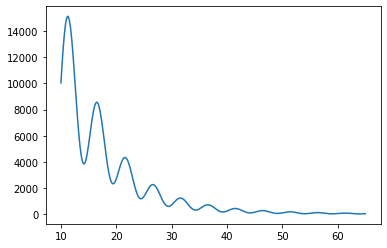

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Scattering_Group/PyMieScatt/scattering_dataset/data.csv',  index_col=0 , header=0).to_numpy()
plt.plot(np.linspace(10,65,256), data[1500][2:])

In [ ]:
batch_size = 50
data_size = len(train_data)

indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

train_indices = indices
train_sampler = SubsetRandomSampler(train_indices)

train_loader = DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler)
test_loader = DataLoader(test_data, batch_size=len(test_data))

In [ ]:
def graphs(loss_history, metrics_history, prediction_arr, labels_arr, epochs):
    plt.figure(figsize=(12,12))
    plt.subplot(321)
    plt.plot(epochs, loss_history, label = 'loss')
    plt.xlabel('Номер эпохи')
    plt.ylabel('Функция потери')
    plt.yscale('log')
    plt.legend()

    plt.subplot(323)
    plt.plot(epochs, metrics_history, label = 'metrics = mape ')
    plt.yscale('log')
    plt.legend()

    plt.subplot(324)
    plt.plot(prediction_arr[:,0],prediction_arr[:,1], linewidth = 0, marker = 'o', label = 'pred' )
    plt.plot(labels_arr[:,0],labels_arr[:,1], linewidth = 0, marker = 'o', label = 'true' )

    plt.xlabel('Относительный показатель преломления m')
    plt.ylabel('Дифракционный параметр x')
    plt.legend()


    plt.subplot(325)
    m_true = labels_arr[:, 0]
    m_pred = prediction_arr[:,0]
    m_err = abs(m_true[:] - m_pred[:])
    plt.hist(m_err, bins = 50)

    length =len(m_err)
    text_1 = "%s" % float('%.2g' % np.median(m_err[(length - 11):(length-1)]))
    print('Абсолютная ошибка m = ' + text_1)
    plt.xlabel('Ошибка по m')
    plt.ylabel('Число частиц')

    plt.subplot(326)
    x_true = labels_arr[:, 1]
    x_pred = prediction_arr[:,1]
    x_err = abs(x_true - x_pred)/x_true*100
    plt.hist(x_err, bins = 50)

    length =len(x_err)
    text_1 = "%s" % float('%.2g' % np.median(x_err[(length - 11):(length-1)]))  #'%s' % float('%.1g' % 0.012)
    print('mape_x = ' + text_1 + '%')
    plt.xlabel('Ошибка по x')
    plt.ylabel('Число частиц')

    plt.show()

In [ ]:
def val_epoch(model, val_loader, metrics):
    model.eval()
    with torch.no_grad():
        metrics_accum = 0
        for i_step, (x, y) in enumerate(val_loader):
            x = x.unsqueeze(1)
            val_prediction = model(x.to(device))
            metrics_value = metrics(val_prediction.cpu().detach().numpy(), y.detach().numpy())
            metrics_accum += metrics_value
    model.train()
    return metrics_accum/i_step

def train_epoch(model, train_loader, loss, metrics):
    metrics_accum = 0
    loss_accum = 0
    prediction_arr = []
    labels_arr = []
    for i_step, (x, y) in enumerate(train_loader):
        x = x.unsqueeze(1)
        prediction = model(x.to(device)).squeeze(1)

        loss_value = loss((prediction/ y.to(device)), torch.ones(prediction.shape).to(device))

        metrics_value= metrics(prediction.cpu().detach().numpy(), y.detach().numpy())

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        metrics_accum += metrics_value
        loss_accum += loss_value.item()

        prediction_arr.append(prediction.cpu().detach().numpy())
        labels_arr.append(y.detach().numpy())

    ave_loss = loss_accum/ i_step
    ave_metrics = metrics_accum/i_step

    return ave_loss, ave_metrics, prediction_arr, labels_arr


In [ ]:
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')
print(device)

cuda


In [ ]:
def train(num_epochs, loss ,metrics, scheduler, val_loader, train_loader):
    loss_history = []
    train_history = []
    val_history = []
    epochs = np.linspace(0,num_epochs, num_epochs)
    for epoch in range(num_epochs):
        model.train()
        ave_loss, ave_metrics, prediction, labels = train_epoch(model, train_loader, loss, metrics)
        scheduler.step()
        print(optimizer.param_groups[0]["lr"])

        #val_history_value = val_epoch(model, val_loader, metrics)

        #val_history.append(val_history_value)
        loss_history.append(float(ave_loss))
        train_history.append(float(ave_metrics))

        print("Epoch: %d, Average loss: %f, average metric (mape): %f" % ((epoch+1), ave_loss, ave_metrics))#, val metric (mape): %f , val_history_value))

    return [loss_history, train_history, val_history, prediction, labels, epochs]

In [ ]:
def test(metrics):
  model.eval()
  with torch.no_grad():
    for i_step, (x, y) in enumerate(test_loader):
        x = x.unsqueeze(1)
        prediction = model(x.to(device)).squeeze(1)

        metrics_value= metrics(prediction.cpu().detach().numpy(), y.detach().numpy())
        prediction_arr = (prediction.cpu().detach().numpy())
        labels_arr = (y.cpu().detach().numpy())


  labels_arr = np.squeeze(labels_arr)
  prediction_arr = np.squeeze(prediction_arr)

  m_true = labels_arr[:,0]
  m_pred = prediction_arr[:,0]
  print('MAPE m-1 (тест) = ',mean_absolute_percentage_error(m_true-1, m_pred-1)*100)
  print('mae m ', mean_absolute_error(m_true, m_pred))
  x_true = labels_arr[:, 1]
  x_pred = prediction_arr[:,1]
  print('MAPE ошибка x (тест) = ' , mean_absolute_percentage_error(x_true, x_pred)*100)

  print("Ошибка (тест): " , mean_absolute_percentage_error(y.detach().numpy(), prediction.cpu().detach().numpy())*100*2)
  return prediction_arr, labels_arr



In [ ]:
class ConvNet_new(nn.Module):
    def __init__(self):
        super(ConvNet_new, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=21, kernel_size=7, padding=3)#lout = 256
        #Lin = Lout => p = (k_s-1)/2
        #Lout = Lin
        self.conv2 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)#lout = 256
        self.conv3 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)#lout = 256
        self.conv4 = nn.Conv1d(in_channels=21, out_channels=21, kernel_size=3, padding=1)#lout = 256

        #Lout = Lin/2 and channels_out*2 (due to 34-layers plains and 34-layers ResNet)  => p = (k-1)/2 - Lin/4
        self.conv5 = nn.Conv1d(in_channels=21, out_channels=42, kernel_size=3, stride = 2, padding=1)# lout =128
        #Lout = Lin
        self.conv6 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=3, padding=1)#lout = 128
        self.conv7 = nn.Conv1d(in_channels=42, out_channels=42, kernel_size=3, padding=1)#lout = 128

        #Lout = Lin/2 and channels_out*2
        self.conv8 = nn.Conv1d(in_channels=42, out_channels=84, kernel_size=3, stride = 2, padding=1)# lout = 64
        #Lout = Lin
        self.conv9 = nn.Conv1d(in_channels=84, out_channels=84, kernel_size=3, padding=1)#lout = 64
        self.conv10 = nn.Conv1d(in_channels=84, out_channels=84, kernel_size=3, padding=1)#lout = 64

        #reducing out_ch value. Lout = Lin
        self.conv11= nn.Conv1d(in_channels=84, out_channels=42, kernel_size=1, padding=0)#lout = 64
        self.conv12= nn.Conv1d(in_channels=42, out_channels=21, kernel_size=1, padding=0)#lout =64
        self.conv13= nn.Conv1d(in_channels=21, out_channels=1, kernel_size=1, padding=0)#lout = 64

        self.fc1 = nn.Linear(64, 2)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))

        return x

#75353 params

In [ ]:
model = ConvNet_new()

In [ ]:
params = sum([np.prod(p.size()) for p in model.parameters()])

In [ ]:
params

75353

In [ ]:
class Modified_seven_ConvNet(nn.Module):
    def __init__(self):
        super(Modified_seven_ConvNet, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=3, padding=2)
        self.bn2 = nn.BatchNorm1d(num_features=2)
        self.conv2 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(num_features=4)
        self.conv3 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=7, padding=2)
        self.bn4 = nn.BatchNorm1d(num_features=8)
        self.conv4 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=11, padding=2)
        self.bn5 = nn.BatchNorm1d(num_features=16)
        self.conv5 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=13, padding=2)
        self.bn6 = nn.BatchNorm1d(num_features=32)
        self.conv6 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=17, padding=2) #out 238
        self.bn7 = nn.BatchNorm1d(num_features=16)
        self.conv7 = nn.Conv1d(in_channels=16, out_channels=8, kernel_size=23, padding=2)#out 212
        self.bn8 = nn.BatchNorm1d(num_features=8)
        self.fc1 = nn.Linear(1696, 180)#
        self.fc2 = nn.Linear(180, 2)


    def forward(self, x):
        x = self.bn1(x)
        x = F.relu(self.conv1(x))
        x = self.bn2(x)
        x = F.relu(self.conv2(x))
        x = self.bn3(x)
        x = F.relu(self.conv3(x))
        x = self.bn4(x)
        x = F.relu(self.conv4(x))
        x = self.bn5(x)
        x = F.relu(self.conv5(x))
        x = self.bn6(x)
        x = F.relu(self.conv6(x))
        x = self.bn7(x)
        x = F.relu(self.conv7(x))
        x = self.bn8(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

#326064 params


TRAIN

In [ ]:
model = ConvNet_new().to(device)
optimizer = torch.optim.Adam(model.parameters())
loss = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 1)

num_epochs = 3
val_loader = 0
history = train(num_epochs = num_epochs, loss = loss, metrics = metrics_mape, scheduler = scheduler, val_loader = val_loader, train_loader = train_loader )
loss_history, train_history ,val_history, pred_train, labels_train, epochs = history[0], history[1], history[2],history[3], history[4], history[5]



In [ ]:
model = ConvNet_new().to(device)

PATH = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/batch0.05k_traindata100k_ConvNet_nosc (2).pt'
#PATH = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_restart.pt'#model = nn.DataParallel(model)

optimizer = torch.optim.Adam(model.parameters())
checkpoint = torch.load(PATH)#, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'], strict=False)#
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epoch']
loss = checkpoint['loss']

loss_history = checkpoint['loss_history']
train_history = checkpoint['train_history']

model.train()

num_epochs = 5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

history = train(num_epochs = num_epochs, loss = loss, metrics = metrics_mape, scheduler = scheduler, val_loader = val_loader, train_loader =train_loader )
loss_history,train_history,  val_history = np.append(loss_history, history[0]), np.append(train_history, history[1]), np.append(val_history, history[2])
epochs = np.linspace(0,len(loss_history) , len(loss_history))

PATH = "/content/drive/MyDrive/Scattering_Group/PyMieScatt/model_FC_Net_loss_mse__data_80k_CosineAnnealingLR_noise_with_validation.pt"
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'loss_history': loss_history,
            'train_history': train_history,
            'val_history': val_history
            }, PATH)

prediction_arr, labels_arr = test(metrics = metrics_mape)#history[3], history[4] #
# graphs(loss_history, train_history, val_history, prediction_arr, labels_arr, epochs)




TEST

In [ ]:
model =Modified_seven_ConvNet().to(device)
PATH = "/content/drive/MyDrive/Scattering_Group/PyMieScatt/model_Modified_seven_ConvNet_loss_mse__data_100k_scheduler_CosineAnnealingLR_noise_without_validation.pt"
optimizer = torch.optim.Adam(model.parameters())

checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epochs = checkpoint['epoch']
loss = checkpoint['loss']
loss_history = checkpoint['loss_history']
train_history = checkpoint['train_history']
val_history = checkpoint['val_history']

epochs = np.linspace(0,len(loss_history) , len(loss_history))

prediction_arr, labels_arr = test(metrics = metrics_mape)#history[3], history[4] #
graphs(loss_history, train_history, val_history, prediction_arr, labels_arr, epochs)



Analysis

In [ ]:
#!pip install PyMieScatt


In [ ]:
import PyMieScatt as ps
sample = prediction_arr[10]
r_i = sample[0]*1.333
d = sample[1]*660/(np.pi*1.333)
_,_,_, ind_nn = ps.ScatteringFunction(m = r_i,
                                          wavelength = 660,
                                          diameter = d,
                                          nMedium = 1.333,
                                          minAngle = 10,
                                          maxAngle = 65,
                                          angularResolution = 55/255,
                                          space = 'theta',
                                          angleMeasure = 'degrees')
plt.plot(np.linspace(10,65,256),ind_nn, label = 'Предсказанная индикатриса')
plt.title('SNR = 5')
plt.legend()
sample = labels_arr[10]
r_i = sample[0]*1.333
d = sample[1]*660/(np.pi*1.333)
_,_,_, ind_mie = ps.ScatteringFunction(m = r_i,
                                          wavelength = 660,
                                          diameter = d,
                                          nMedium = 1.333,
                                          minAngle = 10,
                                          maxAngle = 65,
                                          angularResolution = 55/255,
                                          space = 'theta',
                                          angleMeasure = 'degrees')
plt.plot(np.linspace(10,65,256),ind_mie, label = 'Истинная индикатриса')

plt.xlabel('Азимутальный угол, ɵ')
plt.ylabel("Интенсивность")
plt.legend()
r = 0
for i in range(256):
  r += (ind_nn[i] - ind_mie[i])**2
r/256

Проверка сети, натренированнной на кластере


MAPE m-1 (тест) =  4.6350739896297455
mae m  0.0024309326
MAPE ошибка x (тест) =  0.6553701125085354
Ошибка (тест):  0.876336358487606
Абсолютная ошибка m = 0.0027
mape_x = 0.63%


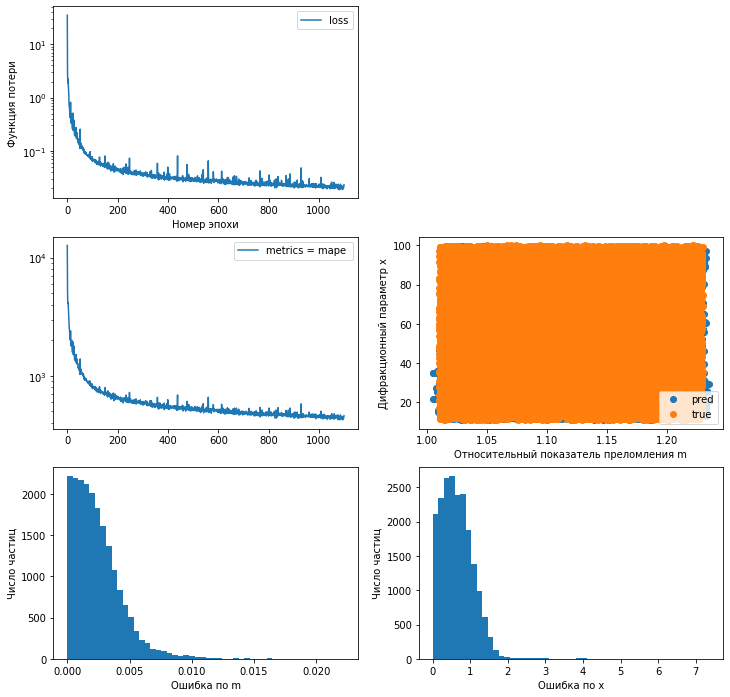

In [ ]:
model = Modified_seven_ConvNet().to(device)
PATH = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/проверка на латексах/batch0.05k_traindata100k_Modified_seven_ConvNet_nosc_check_on_latex_restart6_long.pt'
optimizer = torch.optim.Adam(model.parameters())

checkpoint = torch.load(PATH, map_location=torch.device('cpu'))#, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epochs = checkpoint['epoch']
loss = checkpoint['loss']
loss_history = checkpoint['loss_history']
train_history = checkpoint['train_history']
#val_history = checkpoint['val_history']
epochs = np.linspace(0,len(loss_history) , len(loss_history))
prediction_arr, labels_arr = test(metrics = metrics_mape)

graphs(loss_history, train_history,  prediction_arr, labels_arr, epochs)


Mean absolute error m = 0.0027


Text(0, 0.5, 'Number of particles')

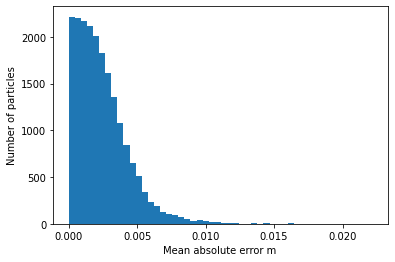

In [ ]:

m_true = labels_arr[:, 0]
m_pred = prediction_arr[:,0]
m_err = abs(m_true[:] - m_pred[:])
plt.hist(m_err, bins = 50)

length =len(m_err)
text_1 = "%s" % float('%.2g' % np.median(m_err[(length - 11):(length-1)]))
print('Mean absolute error m = ' + text_1)
plt.xlabel('Mean absolute error m ')
plt.ylabel('Number of particles')


mape_x = 0.63%


Text(0, 0.5, 'Number of particles')

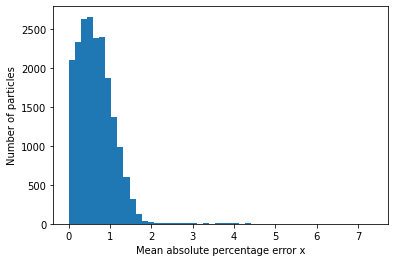

In [ ]:


x_true = labels_arr[:, 1]
x_pred = prediction_arr[:,1]
x_err = abs(x_true - x_pred)/x_true*100
plt.hist(x_err, bins = 50)

length =len(x_err)
text_1 = "%s" % float('%.2g' % np.median(x_err[(length - 11):(length-1)]))  #'%s' % float('%.1g' % 0.012)
print('mape_x = ' + text_1 + '%')
plt.xlabel('Mean absolute percentage error x')
plt.ylabel('Number of particles')


Сравнение размеров батча

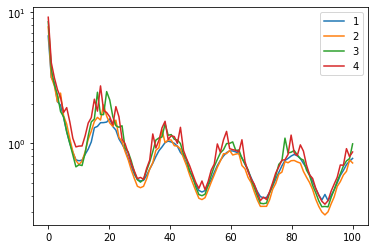

In [ ]:
model = Modified_seven_ConvNet().to(device)

PATH3 = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/batch0.075k_traindata100k_sevenconvnet.pt'
PATH2 = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/batch0.05k_traindata100k_sevenconvnet.pt'
PATH1 = "/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/batch10_traindata100k_sevenconvnet.pt"
PATH4 = '/content/drive/MyDrive/Scattering_Group/PyMieScatt/с кластера/batch0.1k_traindata100k_sevenconvnet.pt'

path_arr = [PATH1,PATH2,PATH3,PATH4]
k = 0
for PATH  in path_arr:
  k = k+1
  checkpoint = torch.load(PATH, map_location=torch.device('cpu'))#, map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  epochs = checkpoint['epoch']
  loss = checkpoint['loss']
  loss_history = checkpoint['loss_history']
  train_history = checkpoint['train_history']

  epochs = np.linspace(0,len(loss_history) , len(loss_history))

  plt.plot(epochs, train_history, label = k )
  plt.yscale('log')
  plt.legend()
